In [51]:
#2016011530-李英杰
import random
import numpy as np
from math import sqrt
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

from numpy import linalg as LA
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import normalize

In [52]:
#加载及查看数据
iris=load_iris()
iris.data
iris.data.shape
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [53]:
def similarity_function(points):
    """
    相似性函数，利用径向基核函数计算相似性矩阵，对角线元素置为０
    对角线元素为什么要置为０我也不清楚，但是论文里是这么说的
    :param points:
    :return:
    """
    res = rbf_kernel(points)
    for i in range(len(res)):
        res[i, i] = 0
    return res
 


# 将数据转化成Graph

In [54]:
#将相似度矩阵转化成图
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import *
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=150, centers=[(1,14),(7.5,1),(14,14)], n_features=2,cluster_std=[3.0,3.0,3.0],random_state=0,shuffle=False)
x=np.array(X)
#字典pos储存150个点的坐标
pos={}
for i in range(1,151):
    pos[i]=x[i-1]

#阈值确定
mat=np.array(similarity_function(iris.data))
mat[mat<0]=0
mat[mat<0.77]=0
print(mat)

[[0.         0.93006575 0.93706746 ... 0.         0.         0.        ]
 [0.93006575 0.         0.97775124 ... 0.         0.         0.        ]
 [0.93706746 0.97775124 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.90937293 0.90257815]
 [0.         0.         0.         ... 0.90937293 0.         0.86286244]
 [0.         0.         0.         ... 0.90257815 0.86286244 0.        ]]


KeyError: 0

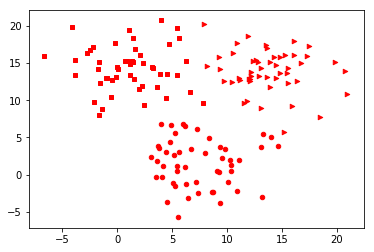

In [55]:
g=nx.Graph()

#添加节点
for i in range(1,151):
    g.add_node(i)
#添加边 
for i in range(150):
    for j in range(150):
        if(mat[i,j]!=0):
            g.add_edge(i, j,weight=mat[i,j])
        
#按簇将节点区分         
nodes1=[i for i in range(1,51)]
nodes2=[i for i in range(51,101)]
nodes3=[i for i in range(101,151)]
#按权重将边区分
edge1 = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] >= 0.9274]
edge2 = [(u, v) for (u, v, d) in g.edges(data=True) if (d['weight'] < 0.9274) & (d['weight'] > 0.8)]
edge3 = [(u, v) for (u, v, d) in g.edges(data=True) if d['weight'] <= 0.8]

#标记点
nx.draw_networkx_nodes(g, pos, node_size=20,nodelist=nodes1,node_shape='s')
nx.draw_networkx_nodes(g, pos, node_size=20,nodelist=nodes2,node_shape='o')
nx.draw_networkx_nodes(g, pos, node_size=20,nodelist=nodes3,node_shape='>')

#标记边
nx.draw_networkx_edges(g, pos, edgelist=edge1,alpha=0.8,width=2)
nx.draw_networkx_edges(g, pos, edgelist=edge2, width=1, alpha=0.5, edge_color='gray')
nx.draw_networkx_edges(g, pos, edgelist=edge3,width=1, alpha=0.5, edge_color='gray', style='dashed')

plt.axis('off')

plt.savefig("weighted_graph.png") # save as png
plt.show()

# 使用谱聚类进行聚类

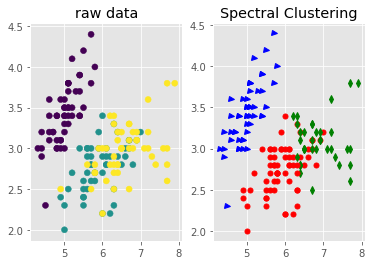

In [56]:
 # encoding=utf-8 
def spectral_clustering(points, k):

    #谱聚类
    #:param points: 样本点
    #:param k: 聚类个数
    #:return: 聚类结果
    W = similarity_function(points)
    # 度矩阵D可以从相似度矩阵W得到，这里计算的是D^(-1/2)
    # D = np.diag(np.sum(W, axis=1))
    # Dn = np.sqrt(LA.inv(D))
    # 本来应该像上面那样写，我做了点数学变换，写成了下面一行
    Dn = np.diag(np.power(np.sum(W, axis=1), -1.2))
    # 拉普拉斯矩阵：L=Dn*(D-W)*Dn=I-Dn*W*Dn
    # 也是做了数学变换的，简写为下面一行
    L = np.eye(len(points)) - np.dot(np.dot(Dn, W), Dn)
    eigvals, eigvecs = LA.eig(L)
    # 前k小的特征值对应的索引，argsort函数
    indices = np.argsort(eigvals)[:k]
    # 取出前k小的特征值对应的特征向量，并进行正则化
    k_smallest_eigenvectors = normalize(eigvecs[:, indices])
    # 利用KMeans进行聚类
    return KMeans(n_clusters=3).fit_predict(k_smallest_eigenvectors)
    
X=iris.data
y=iris.target
labels = spectral_clustering(X, 3)
 
# 画图
plt.style.use('ggplot')
mark = ['or', '>b', 'dg']
# 原数据
fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.scatter(X[:, 0], X[:, 1], c=y)
ax0.set_title('raw data')
# 谱聚类结果
color = 0
j = 0 
for i in labels:
    plt.plot([X[j:j+1,0]], [X[j:j+1,1]], mark[i], markersize = 5)
    j +=1
ax1.set_title('Spectral Clustering')
plt.show()

In [57]:
#计算准确率
from sklearn import metrics
print ( metrics.homogeneity_completeness_v_measure(iris.target, labels))

(0.7869234996582516, 0.8093691546872486, 0.7979885217013319)


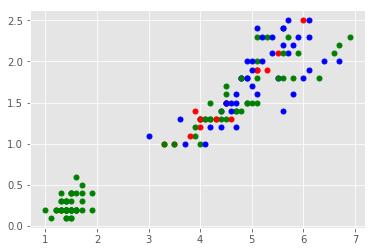

(0.22235998916966734, 0.2685550822017027, 0.24328405727293526)


D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


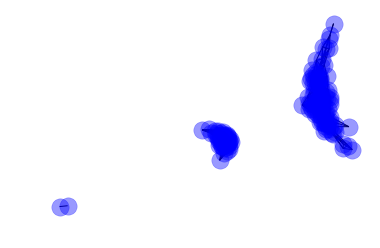

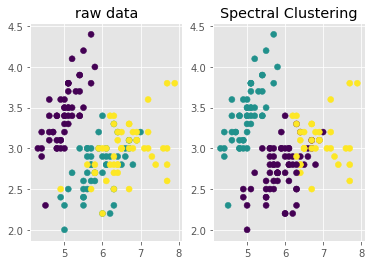

(0.7869234996582516, 0.8093691546872486, 0.7979885217013319)


In [ ]:
 # H'shape is n*n

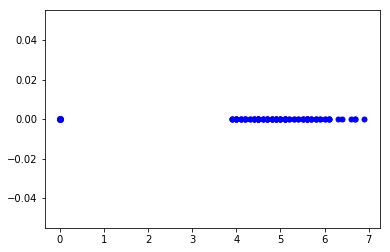

array([1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])